In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
DENSE = False
EPS = 120
LAG = 12 + 1
SROUTE = [
    '400860-400861', 
    '400861-403781',
#     '400861-400948',
#     '400861-405376',
]
HSIZE = 128
STOPS = len(SROUTE)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [4]:
dset = SpotHistory(SROUTE, 'train', 16, lag=LAG, res=10).generator()
evalset = SpotHistory(SROUTE, 'test', 16, lag=LAG, res=10).generator()

Chunks (lag 13)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
    * [400861-403781]: 90
 [*] Examples (train): 11699
Chunks (lag 13)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
    * [400861-403781]: 90
 [*] Examples (test): 11699


In [8]:
from models.GRNN import *
model = GRNN(nodes=len(SROUTE), hidden_size=HSIZE, steps=STOPS).to(device)
model.device = device
criterion, opt, sch = model.params(lr=0.005)
evf = lambda: evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())
_ = evf()

Eval loss: 94.15828     


In [9]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(evf())
    sys.stdout.flush()
    sch.step()

[1/120 : 732/732] - L7.32       
Eval loss: 2.55843    
[2/120 : 732/732] - L0.64      
Eval loss: 1.57455    
[3/120 : 732/732] - L0.34      
Eval loss: 1.24541    
[4/120 : 732/732] - L1.20      
Eval loss: 1.10312    
[5/120 : 732/732] - L1.07      
Eval loss: 1.01844    
[6/120 : 732/732] - L0.31      
Eval loss: 0.95624    
[7/120 : 732/732] - L0.73      
Eval loss: 0.90194    
[8/120 : 732/732] - L1.05      
Eval loss: 0.85366    
[9/120 : 732/732] - L0.54      
Eval loss: 0.81222    
[10/120 : 732/732] - L1.50      
Eval loss: 0.77540    
[11/120 : 732/732] - L0.57      
Eval loss: 0.74067    
[12/120 : 732/732] - L0.59      
Eval loss: 0.70972    
[13/120 : 732/732] - L0.98      
Eval loss: 0.68109    
[14/120 : 732/732] - L0.18      
Eval loss: 0.65580    
[15/120 : 732/732] - L1.65      
Eval loss: 0.63399    
[16/120 : 732/732] - L0.27      
Eval loss: 0.60783    
[17/120 : 732/732] - L0.41      
Eval loss: 0.58739    
[18/120 : 732/732] - L0.52      
Eval loss: 0.56913    


Process Process-184:
Process Process-183:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 104, in get
    if timeout < 0 or not self._poll(timeout):
  File 

KeyboardInterrupt: 

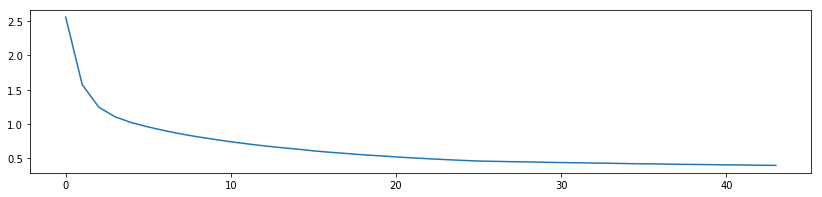

In [10]:
plt.figure(figsize=(14, 3))
plt.plot(eval_mse)
plt.show(); plt.close()

Eval segments: 18
Eval MSE: 0.4657


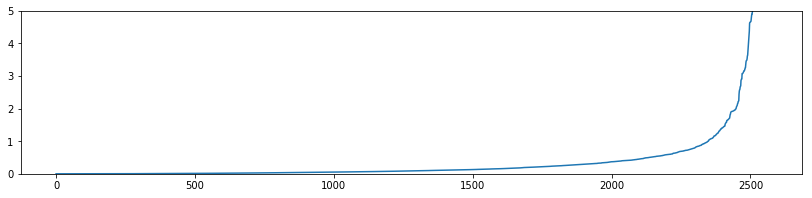

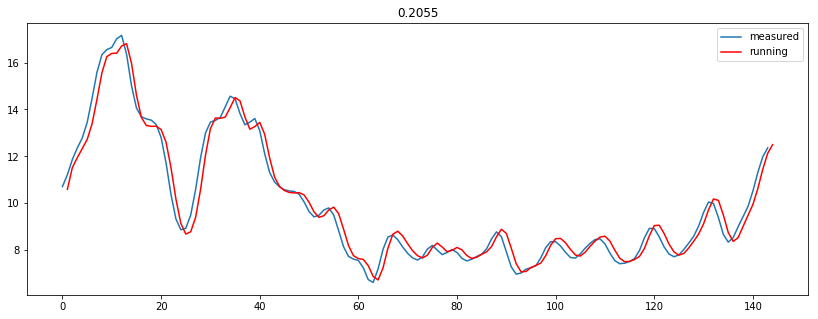

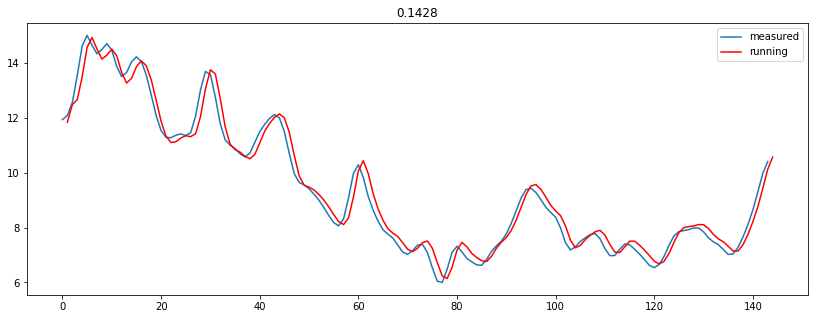

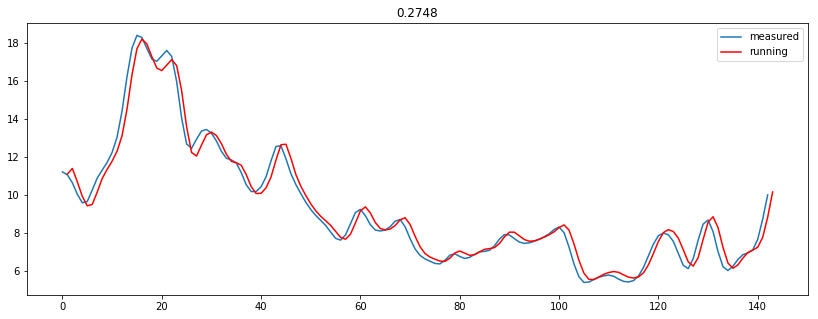

In [17]:
def xfmt(datain):
    bynode = torch.split(datain.to(device).float().unsqueeze(1), 1, 2)
    return bynode

from utils import *
viewset = SpotHistory(SROUTE, 'test', 16, lag=None, res=10, shuffle=False, verbose=False)

sqerr = eval_rnn(viewset, model, plot=False, xfmt=xfmt)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

plt.figure(figsize=(14, 3))
plt.plot(sorted(sqerr)); plt.ylim(0, 5)
plt.show(); plt.close()

_ = eval_rnn(viewset[:3], model, plot=True, xfmt=xfmt)